In [481]:
from numpy.random import uniform
from numpy import multiply
import numpy as np
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
%matplotlib inline

import random
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import Grid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner


In [482]:
#the terrain function
def fake_surface(dim=(100,100), low=500, high=1500, sigma=2):
    '''Super basic random terrain function.
    
    This function generates a uniform random surface,
    and applies a sequence (x and y) of one-dimensional
    convolution filters; effectively increasing the spatial
    autocorrelation of the surface relative to sigma.
    
    Paramters
    ---------
    dim : tuple
        The x and y dimensions of the 'terrain' grid.
    low : numeric
        The lowest possible simulated elevation value.
    high : numeric
        The highest possible simulated elevation value.
    sigma : numeric
        The variance of the gaussian kernel. Controls
        the 'smoothness' of the simulated surface.
        Values between 1 and 3 are probably good for
        'small' surfaces.
        
    Returns
    -------
    out : ndarray
        A spatially autocorrelated random 'terrain' surface
        of a given dimension.
    '''
    r = uniform(low, high, size=multiply(*dim)).reshape(dim)
    return gaussian_filter(r, sigma=sigma, truncate=9)

In [483]:
#the wild fire CA definition:
class TreeCell(Agent): # object
    '''
    A tree cell.
    
    Attributes:
        x, y: Grid coordinates
        condition: Can be "Fine", "On Fire", or "Burned Out"
        unique_id: (x,y) tuple. 
    
    unique_id isn't strictly necessary here, but it's good practice to give one to each
    agent anyway.
    '''
    def __init__(self, model, pos):
        '''
        Create a new tree.
        Args:
            pos: The tree's coordinates on the grid. Used as the unique_id
        '''
        #super().__init__(pos, model)
        Agent.__init__(self, pos, model) #I had to change the previous line to this to make it work.
        
        self.pos = pos
        self.unique_id = pos
        self.condition = "Fine"
        
    def step(self):
        '''
        If the tree is on fire, spread it to fine trees nearby.
        '''
        if self.condition == "On Fire":
            neighbors = self.model.grid.get_neighbors(self.pos, moore=False)
            for neighbor in neighbors:
                if neighbor.condition == "Fine":
                    neighbor.condition = "On Fire"
            self.condition = "Burned Out"

class ForestFire(Model):
    '''
    Simple Forest Fire model.
    '''
    def __init__(self, height, width, density):
        '''
        Create a new forest fire model.
        
        Args:
            height, width: The size of the grid to model
            density: What fraction of grid cells have a tree in them.
        '''
        # Initialize model parameters
        self.height = height
        self.width = width
        self.density = density
        
        # Set up model objects
        self.schedule = RandomActivation(self)
        self.grid = Grid(height, width, torus=False)
        self.dc = DataCollector({"Fine": lambda m: self.count_type(m, "Fine"),
                                "On Fire": lambda m: self.count_type(m, "On Fire"),
                                "Burned Out": lambda m: self.count_type(m, "Burned Out")})
        
        self.grids = list() # empty list to collect the grids of the time steps
        
        # Place a tree in each cell with Prob = density
        for x in range(self.width):
            for y in range(self.height):
                if random.random() < self.density:
                    # Create a tree
                    new_tree = TreeCell(self, (x, y))
                    # Set all trees in the first column on fire.
                    if x == 0:
                        new_tree.condition = "On Fire"
                    self.grid[y][x] = new_tree
                    self.schedule.add(new_tree)
        self.running = True

    #adding method to collect the grid at a timestep:
    
    def fetch_grid(self):
        #create a numpy array with the cell states converted as integers for each time step
        cell_conditions=np.zeros((self.height,self.width)) 
        for tree in self.schedule.agents:
            (currx,curry) = tree.pos
            if tree.condition == "Fine":
                cell_conditions[curry][currx] = 3
            if tree.condition == "On Fire":
                cell_conditions[curry][currx] = 2
            if tree.condition == "Burned Out":
                cell_conditions[curry][currx] = 1     
    
        self.grids.append(cell_conditions)

  
        
    def step(self):
        '''
        Advance the model by one step.
        '''
        self.schedule.step()
        self.dc.collect(self)
        self.fetch_grid()
        # Halt if no more fire
        if self.count_type(self, "On Fire") == 0:
            self.running = False
        
        
    
    @staticmethod
    def count_type(model, tree_condition):
        '''
        Helper method to count trees in a given condition in a given model.
        '''
        count = 0
        for tree in model.schedule.agents:
            if tree.condition == tree_condition:
                count += 1
        return count    

In [484]:
#run the model:
fire = ForestFire(100, 100, 0.6)
fire.run_model()

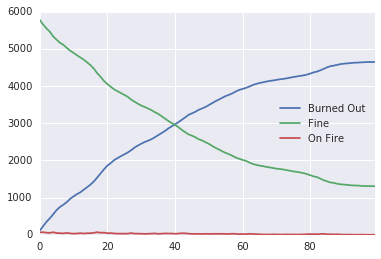

In [485]:
#visualize results:
results = fire.dc.get_model_vars_dataframe()
results.plot()

Wildfire state in step 10


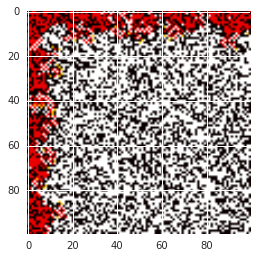

Wildfire state in step 20


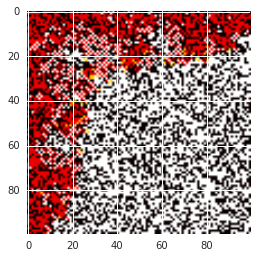

Wildfire state in step 30


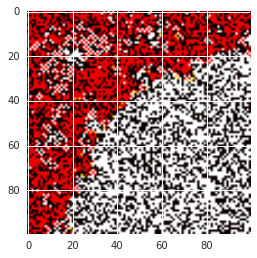

Wildfire state in step 40


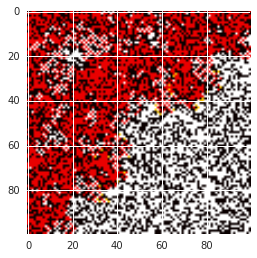

Wildfire state in step 50


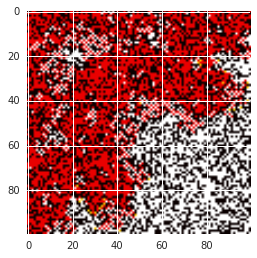

Wildfire state in step 60


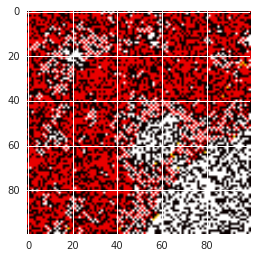

Wildfire state in step 70


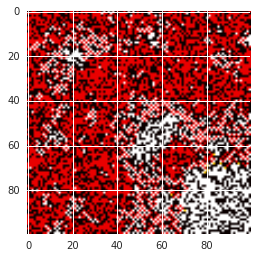

Wildfire state in step 80


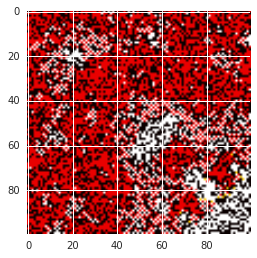

Wildfire state in step 90


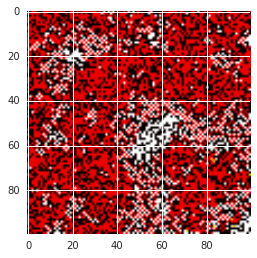

Wildfire state in step 100


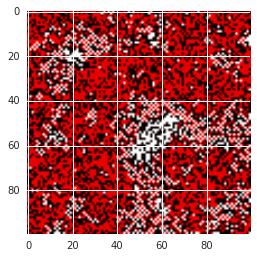

In [486]:
#visualize cells using heatmap:
visualize_frequency = 10 #plot every n step
count=0
for current_grid in fire.grids:
    #print current_grid.grid[70][30].condition
    count+=1
    if count%visualize_frequency==0: #for each step to be visualised:

        print "Wildfire state in step %s" % str(count)       
        plt.imshow(current_grid,cmap=plt.get_cmap("hot"))
        plt.show()


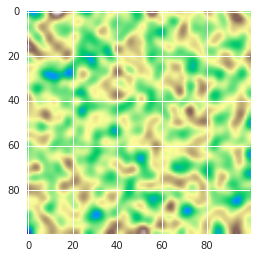

In [487]:
plt.imshow(fake_surface((100,100)), cmap=plt.get_cmap("terrain"))
plt.show()